In [2]:
import pandas as pd
import numpy as np

# Analysis of data set
Data set downloaded from: https://www.kaggle.com/jvanelteren/boardgamegeek-reviews
### Since our project is restricted to predict the rating, given a review, I will be just using bgg-15m-reviews.csv file.
##### *partially based on kaggle bot's analysis 

In [3]:
# reading the data set from csv files
column_names = pd.read_csv('./Dataset/bgg-15m-reviews.csv',header = None, nrows=1)
dataframe = pd.read_csv('./Dataset/bgg-15m-reviews.csv', header = None, skiprows = 1)
column_list = np.concatenate(column_names.values, axis=0).tolist()
column_list[0] = 'index'
dataframe.columns = column_list
del column_names

In [4]:
print('*'*30,'Table Data','*'*30)
print(dataframe.head())
print('*'*30,'Table Data summary','*'*30)
print(dataframe.describe())

****************************** Table Data ******************************
   index             user  rating  \
0      0          Torsten    10.0   
1      1  mitnachtKAUBO-I    10.0   
2      2           avlawn    10.0   
3      3       Mike Mayer    10.0   
4      4          Mease19    10.0   

                                             comment     ID      name  
0                                                NaN  30549  Pandemic  
1  Hands down my favorite new game of BGG CON 200...  30549  Pandemic  
2  I tend to either love or easily tire of co-op ...  30549  Pandemic  
3                                                NaN  30549  Pandemic  
4  This is an amazing co-op game.  I play mostly ...  30549  Pandemic  
****************************** Table Data summary ******************************
              index        rating            ID
count  1.582327e+07  1.582327e+07  1.582327e+07
mean   7.911634e+06  7.054843e+00  9.507796e+04
std    4.567784e+06  1.599649e+00  8.411524e+04

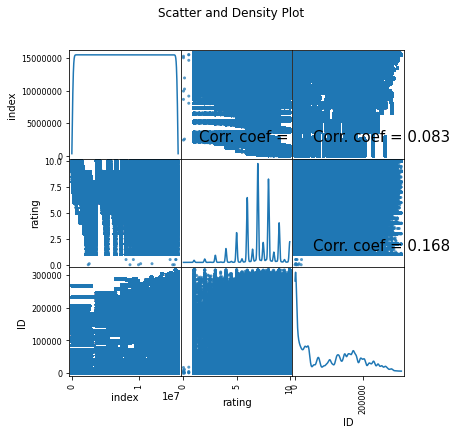

In [5]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import os # accessing directory structure

def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

plotScatterMatrix(dataframe, 6, 15)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002E7FFDAB970>]],
      dtype=object)

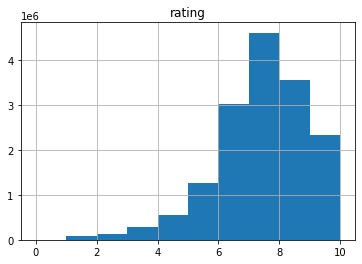

In [6]:
dataframe.hist(column='rating')

# Data set cleaning
### remove punctuations, lemmatization, stop words removal

In [7]:
# drop the rows with empty rating
dataframe.dropna(subset=['rating'])

# droping columns that are not required
dataframe = dataframe[['rating', 'comment']]

In [8]:
%%time
import nltk
# download wordnet if required
# nltk.download('wordnet')
# download stopwords if required
# nltk.download('stopwords')
# loading English stop words  
stop_words = nltk.corpus.stopwords.words('english')
import string
import re

# Basic cleaning
def cleanAndTokenize(review):
    # removing punctuations
    non_punc_words = "".join([character for character in review if character not in string.punctuation])
    
    non_punc_words = non_punc_words.strip()
    
    # tokenizing reviews
    list_of_token = re.split('\W+',non_punc_words)
    
    # removing stop words
    tokens = [word for word in list_of_token if word not in stop_words]
    
    return tokens

# converting words to lower case.
dataframe['comment'] = dataframe['comment'].apply(lambda review : cleanAndTokenize(str(review).lower()))

# using nltk's wordnet lemmatizer
word_net_lemma = nltk.WordNetLemmatizer()

def lemmatize_data(token_list):
    tokens = [word_net_lemma.lemmatize(word) for word in token_list]
    return tokens

dataframe['comment'] = dataframe['comment'].apply(lambda review : lemmatize_data(review))

dataframe = dataframe[~dataframe['comment'].isin(['nan'])]

# un-comment to write data to file
# dataframe.to_csv('./Cleaned_dataset/tokenized_words.csv',index = False, header=True)

Wall time: 16h 27min 54s
Parser   : 514 ms


In [20]:
# joining the list of words to form a string for input to count vectorizer
dataframe['comment'] = dataframe['comment'].apply(lambda review : " ".join(review))

# un-comment to write data to file
# dataframe.to_csv('./Cleaned_dataset/tokenized_words_joined.csv',index = False, header=True)

# Splitting of Data set into train, test and development sets 

In [22]:
dataframe = pd.read_csv('./Cleaned_dataset/tokenized_words_joined.csv')

# dividing the data set into test dev and train split
train, development, test = np.split(dataframe.sample(frac=1, random_state=5), [int(.6*len(dataframe)), int(.8*len(dataframe))])

print('size of train data set: ',train.shape[0])
print(train.head())
print('*'*100)
print('size of development data set: ',development.shape[0])
print(development.head())
print('*'*100)
print('size of test data set: ',test.shape[0])
print(test.head())

size of train data set:  1797013
         rating                                            comment
2975889     5.0  got part card humanity ten day whatever kwanza...
1564557     5.0  ugly board doesnt match rather nice box artwor...
533178      5.0  please stop playing 7 player 7 player trash ex...
914853      7.0                player 3 4 5 best 5 expansion order
1611838     8.0  der geist de weines al brettspiel hier der lux...
****************************************************************************************************
size of development data set:  599005
         rating                                            comment
27304      10.0          could go wrong game perfect never get old
2573139     7.0                                               2020
1919617     9.0  rule simple enough taught kid play strategy co...
1148951     7.0             fun light game need think hard playing
1139124     6.0  cardcrafting great artwork nice like play occa...
************************

# Hyper-parameter tuning K.N.N.

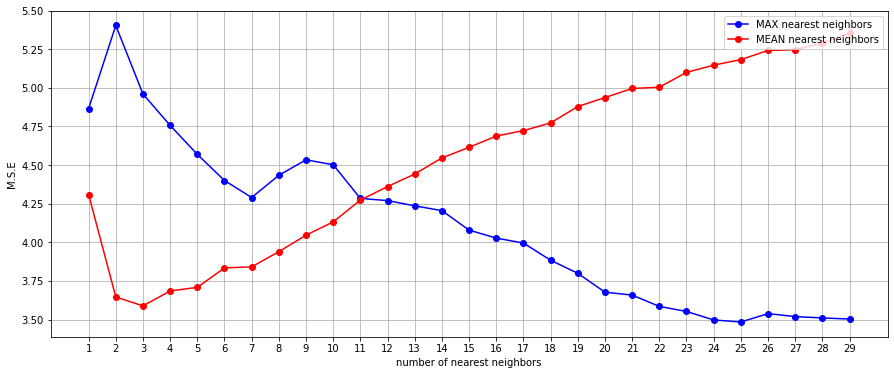

Wall time: 8h 10min 7s
Parser   : 704 ms


In [55]:
%%time
import matplotlib.pyplot as plt
import nltk
# download wordnet if required
# nltk.download('wordnet')
# download stopwords if required
# nltk.download('stopwords')
# loading English stop words  
stop_words = nltk.corpus.stopwords.words('english')
import string
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances
import numpy as np

vectorizer_obj = CountVectorizer(preprocessor=None)#analyzer='word', ngram_range=(2, 2))
count_vector_obj = vectorizer_obj.fit_transform(train['comment'].apply(lambda x: np.str_(x)))

# converting the float values to int 
class_data = pd.DataFrame(train['rating'],dtype='int')

max_nn = 30
plot_max = []
plot_mean = []

for nearest_neighbor in range(1,max_nn):
    max_predicted_rating_arr = []
    mean_predicted_rating_arr = []
    actual_rating_arr = []
    for row in development.iterrows():
        actual_rating = int(row[1]['rating'])
        test_review = str(row[1]['comment'])
        
        input_count_obj = vectorizer_obj.transform([test_review])
        
        cosine_distance_list = cosine_distances(count_vector_obj,input_count_obj)
        dict_class_label = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0}

        distance_set = np.unique(cosine_distance_list)
        distance_set = sorted(distance_set)
        min_dist = distance_set[0:nearest_neighbor]
        for k in min_dist:
            list1 = np.where(cosine_distance_list == k)[0]
            class_label,label_count = np.unique(class_data.iloc[list1,:].values,return_counts = True)
            for index,value in zip(class_label.tolist(),label_count.tolist()):
                dict_class_label[index] += value
        actual_rating_arr.append(actual_rating)
        max_predicted_rating_arr.append(max(dict_class_label, key=lambda key: dict_class_label[key]))

        list_of_rating = [val for val in dict_class_label if dict_class_label[val] > 0]
        mean_predicted_rating_arr.append(int(sum(list_of_rating)/len(list_of_rating)))
    MSE = pd.DataFrame(columns = ['max_predicted_rating_arr','mean_predicted_rating_arr','actual_rating_arr'])
    MSE['actual_rating_arr'] = actual_rating_arr
    MSE['max_predicted_rating_arr'] = max_predicted_rating_arr
    MSE['mean_predicted_rating_arr'] = mean_predicted_rating_arr
    mean_squared_error_max = np.square(np.subtract(MSE['actual_rating_arr'],MSE['max_predicted_rating_arr'])).mean()
    mean_squared_error_mean = np.square(np.subtract(MSE['actual_rating_arr'],MSE['mean_predicted_rating_arr'])).mean()
    plot_max.append(mean_squared_error_max)
    plot_mean.append(mean_squared_error_mean)
    
# Plot the mean v/s max values
plt.figure(figsize=(15,6))
plt.plot(list(range(1, max_nn)),plot_max,'b-o', label = 'MAX nearest neighbors')
plt.plot(list(range(1, max_nn)),plot_mean,'r-o', label = 'MEAN nearest neighbors')
plt.legend(loc='upper right')
plt.xlabel('number of nearest neighbors')
plt.ylabel('M.S.E')
plt.xticks(list(range(1, max_nn)))
plt.grid()
plt.show()

# Hyper-parameter tuning Naive Bayes.

C:\Users\Varun\anaconda3\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


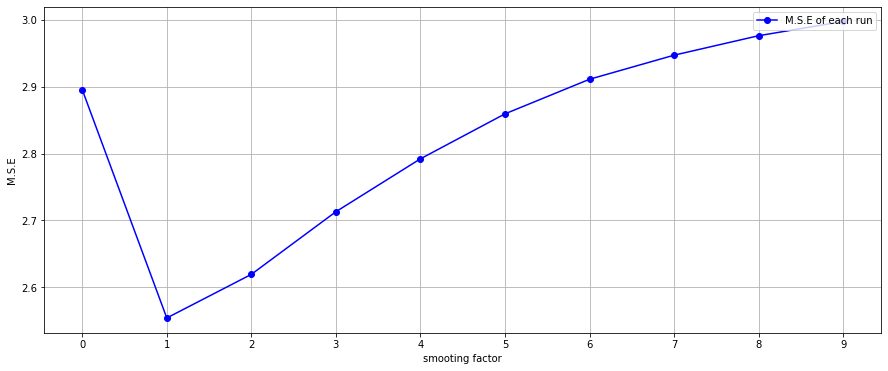

In [61]:
import numpy as np
import matplotlib.pyplot as plt

alpha_arr = list(range(0,10))

vectorizer_obj = CountVectorizer()#analyzer='word', ngram_range=(2, 2))
count_vector_obj = vectorizer_obj.fit_transform(train['comment'].apply(lambda x: np.str_(x)))

class_data = pd.DataFrame(train['rating'],dtype='int')
# converting to 1-D array
class_data = np.ravel(class_data)
plot_NB = []

for alpha_in in alpha_arr:
    MNB_obj = MultinomialNB(alpha=alpha_in)
    MNB_obj.fit(count_vector_obj, class_data)
    actual_rating_arr = []
    NB_predicted_rating_arr = []
    for row in development.iterrows():
        actual_rating = int(row[1]['rating'])
        test_review = str(row[1]['comment'])
        actual_rating_arr.append(actual_rating)
        
        input_count_obj = vectorizer_obj.transform([test_review])
        
        NB_prediction = MNB_obj.predict(input_count_obj)
        NB_predicted_rating_arr.append(int(NB_prediction[0]))
    MSE = pd.DataFrame(columns = ['NB_predicted_rating_arr','actual_rating_arr'])
    MSE['actual_rating_arr'] = actual_rating_arr
    MSE['NB_predicted_rating_arr'] = NB_predicted_rating_arr
    mean_squared_error_NB = np.square(np.subtract(MSE['actual_rating_arr'],MSE['NB_predicted_rating_arr'])).mean()
    plot_NB.append(mean_squared_error_NB)

# Plot the mean v/s max values
plt.figure(figsize=(15,6))
plt.plot(alpha_arr,plot_NB,'b-o',label = 'M.S.E of each run')
plt.legend(loc='upper right')
plt.xlabel('smooting factor')
plt.ylabel('M.S.E')
plt.xticks(alpha_arr)
plt.grid()
plt.show()

# Final testing on the test data set 

#### K-nearest-neighbor

In [70]:
vectorizer_obj = CountVectorizer(preprocessor=None)#analyzer='word', ngram_range=(2, 2))
count_vector_obj = vectorizer_obj.fit_transform(train['comment'].apply(lambda x: np.str_(x)))

# converting the float values to int 
class_data = pd.DataFrame(train['rating'],dtype='int')
actual_rating_arr = []
max_predicted_rating_arr = []
mean_predicted_rating_arr = []

for row in test.iterrows():
    actual_rating = int(row[1]['rating'])
    test_review = str(row[1]['comment'])

    input_count_obj = vectorizer_obj.transform([test_review])

    cosine_distance_list = cosine_distances(count_vector_obj,input_count_obj)
    dict_class_label = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0}

    distance_set = np.unique(cosine_distance_list)
    distance_set = sorted(distance_set)
    min_dist = distance_set[0:25]
    for k in min_dist:
        list1 = np.where(cosine_distance_list == k)[0]
        class_label,label_count = np.unique(class_data.iloc[list1,:].values,return_counts = True)
        for index,value in zip(class_label.tolist(),label_count.tolist()):
            dict_class_label[index] += value
    actual_rating_arr.append(actual_rating)
    max_predicted_rating_arr.append(max(dict_class_label, key=lambda key: dict_class_label[key]))

for row in test.iterrows():
    actual_rating = int(row[1]['rating'])
    test_review = str(row[1]['comment'])

    input_count_obj = vectorizer_obj.transform([test_review])

    cosine_distance_list = cosine_distances(count_vector_obj,input_count_obj)
    dict_class_label = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0}

    distance_set = np.unique(cosine_distance_list)
    distance_set = sorted(distance_set)
    min_dist = distance_set[0:3]
    for k in min_dist:
        list1 = np.where(cosine_distance_list == k)[0]
        class_label,label_count = np.unique(class_data.iloc[list1,:].values,return_counts = True)
        for index,value in zip(class_label.tolist(),label_count.tolist()):
            dict_class_label[index] += value
    list_of_rating = [val for val in dict_class_label if dict_class_label[val] > 0]
    mean_predicted_rating_arr.append(int(sum(list_of_rating)/len(list_of_rating)))

MSE = pd.DataFrame(columns = ['max_predicted_rating_arr','mean_predicted_rating_arr','actual_rating_arr'])
MSE['actual_rating_arr'] = actual_rating_arr
MSE['max_predicted_rating_arr'] = max_predicted_rating_arr
MSE['mean_predicted_rating_arr'] = mean_predicted_rating_arr
mean_squared_error_max = np.square(np.subtract(MSE['actual_rating_arr'],MSE['max_predicted_rating_arr'])).mean()
mean_squared_error_mean = np.square(np.subtract(MSE['actual_rating_arr'],MSE['mean_predicted_rating_arr'])).mean()

print('K.N.N max approach M.S.E = ',mean_squared_error_max)
print('K.N.N mean approach M.S.E = ',mean_squared_error_mean)

K.N.N max approach M.S.E =  3.064
K.N.N mean approach M.S.E =  3.432


#### Naive Bayes

In [69]:
vectorizer_obj = CountVectorizer()#analyzer='word', ngram_range=(2, 2))
count_vector_obj = vectorizer_obj.fit_transform(train['comment'].apply(lambda x: np.str_(x)))

class_data = pd.DataFrame(train['rating'],dtype='int')
# converting to 1-D array
class_data = np.ravel(class_data)

NB_predicted_rating_arr = []
actual_rating_arr = []

for row in test.iterrows():
    actual_rating = int(row[1]['rating'])
    test_review = str(row[1]['comment'])
    actual_rating_arr.append(actual_rating)

    input_count_obj = vectorizer_obj.transform([test_review])

    NB_prediction = MNB_obj.predict(input_count_obj)
    NB_predicted_rating_arr.append(int(NB_prediction[0]))

MSE = pd.DataFrame(columns = ['NB_predicted_rating_arr','actual_rating_arr'])
MSE['actual_rating_arr'] = actual_rating_arr
MSE['NB_predicted_rating_arr'] = NB_predicted_rating_arr
mean_squared_error_NB = np.square(np.subtract(MSE['actual_rating_arr'],MSE['NB_predicted_rating_arr'])).mean()
print('Naive Bayes MSE for alpha=1 : ',mean_squared_error_NB)

Naive Bayes MSE for alpha=1 :  2.931


# Final models to try user based inputs 

### Step 1: Initialize the count vector 

In [24]:
%%time
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

dataframe = pd.read_csv('./Cleaned_dataset/tokenized_words_joined.csv')

vectorizer_obj = CountVectorizer()
count_vector_obj = vectorizer_obj.fit_transform(dataframe['comment'].apply(lambda x: np.str_(x)))

class_data = pd.DataFrame(dataframe['rating'],dtype='int')

Wall time: 9min 27s
Parser   : 1.55 s


### Step 2: Enter the input and press enter

In [31]:
import nltk
# download wordnet if required
# nltk.download('wordnet')
# download stopwords if required
# nltk.download('stopwords')
# loading English stop words  
stop_words = nltk.corpus.stopwords.words('english')
import string
import re

# Run this cell to enter a new review, post entering the review hit enter to stop taking input.
input_review = input()

# preprocessing of input and vectorization
# removing punctuations
non_punc_words = "".join([character for character in input_review if character not in string.punctuation])

non_punc_words = non_punc_words.strip()

# tokenizing reviews
list_of_tokens = re.split('\W+',non_punc_words)

# removing stop words
tokens = [word for word in list_of_tokens if word not in stop_words]

# lower case words
tokens = [word.lower() for word in tokens]

# lemmatization
# using nltk's wordnet lemmatizer
word_net_lemma = nltk.WordNetLemmatizer()
tokens = [word_net_lemma.lemmatize(word) for word in tokens]

clean_input_string = " ".join(tokens)

input_count_obj = vectorizer_obj.transform([clean_input_string])

good game,would like to recommend it!


### Step 3: Run Below cells to get predictions

#### K.N.N

In [32]:
%%time
from sklearn.metrics.pairwise import cosine_distances

cosine_distance_list = cosine_distances(count_vector_obj,input_count_obj)

dict_class_label = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0}

distance_set = np.unique(cosine_distance_list)
distance_set = sorted(distance_set)
min_dist = distance_set[0:3]
for k in min_dist:
    list1 = np.where(cosine_distance_list == k)[0]
    class_label,label_count = np.unique(class_data.iloc[list1,:].values,return_counts = True)
    for index,value in zip(class_label.tolist(),label_count.tolist()):
        dict_class_label[index] += value
print('max count predicted rating: ',max(dict_class_label, key=lambda key: dict_class_label[key]))

min_dist = distance_set[0:25]
for k in min_dist:
    list1 = np.where(cosine_distance_list == k)[0]
    class_label,label_count = np.unique(class_data.iloc[list1,:].values,return_counts = True)
    for index,value in zip(class_label.tolist(),label_count.tolist()):
        dict_class_label[index] += value

list_of_rating = [val for val in dict_class_label if dict_class_label[val] > 0]
print('mean predicted rating: ',int(sum(list_of_rating)/len(list_of_rating)))

max count predicted rating:  7
mean predicted rating:  5
Wall time: 3.11 s


#### Naive Bayes

In [33]:
%%time
from sklearn.naive_bayes import MultinomialNB

class_data_ravel = np.ravel(class_data)

MNB_obj = MultinomialNB(alpha=1)
MNB_obj.fit(count_vector_obj, class_data_ravel)

NB_prediction = MNB_obj.predict(input_count_obj)
print("The estimated rating is: ", str(NB_prediction[0]))

The estimated rating is:  8
Wall time: 2.22 s


## Pickle the objects to export 

In [21]:
import pickle

# count_vectorizer object
pickle.dump(count_vector_obj,open('./pickled_objects/count_vector_obj.pickle','wb'))

# Naive Bayes object
pickle.dump(MNB_obj,open('./pickled_objects/MNB_obj.pickle','wb'))

print('Object pickling completed!')

Object pickling completed!
